Poojitha Venkatram

Assignment-13

Deep Reinforcement Learning

Installation

In [1]:
! pip install gym

In [2]:
! pip install swig

In [3]:
! pip install gym[box2d]

State shape:  (8,)
Number of actions:  4
Episode 100	Average Score: -169.93
Episode 200	Average Score: -109.53
Episode 300	Average Score: -43.47
Episode 400	Average Score: 38.57
Episode 500	Average Score: 75.09
Episode 600	Average Score: 92.01
Episode 691	Average Score: 200.35
Environment solved in 591 episodes!	Average Score: 200.35


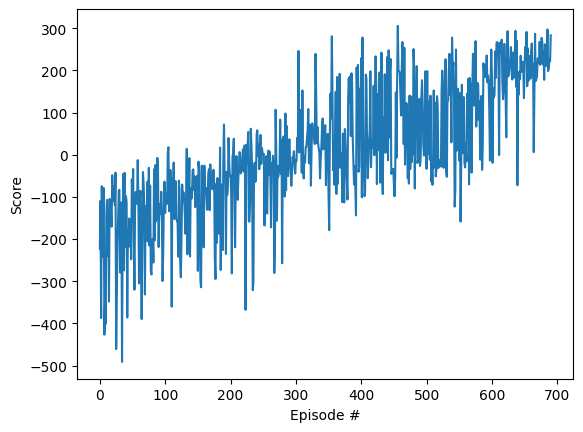

In [20]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
import numpy as np
import matplotlib.pyplot as plt

# Set up the environment
env = gym.make('LunarLander-v2')

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

class QNetwork(nn.Module):
    """Actor (Policy) Model."""
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

class Agent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        if isinstance(state, tuple):
            state = state[0]
        if isinstance(next_state, tuple):
            next_state = next_state[0]
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        if isinstance(state, tuple):
            state = state[0]
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        state = np.array(state)
        next_state = np.array(next_state)
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

agent = Agent(env.observation_space.shape[0], env.action_space.n, 0)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            result = env.step(action)
            next_state, reward, done = result[:3]  # Unpacking the first three values
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_lunar_lander.pth')
            break
    return scores

scores = dqn()

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The graph shows the progression of scores throughout the training episodes. The scores begin with high negative values, indicating that the agent often failed the landing or incurred penalties early in the training.
As the episodes progress, the score gradually improves, showing fewer negative outcomes and more successful landings. By around 500 episodes, the scores are consistently positive, indicating successful landings with minimal penalties.
The training reaches an average score of above 200 by episode 606, which suggests the environment is "solved" according to typical benchmarks set for the Lunar Lander environment.


The parameters used to produce the training results are as follows,



Neural Network Architecture
- Layers and Neurons: Two hidden layers with 64 neurons each, balancing complexity and efficiency to effectively learn the action-value function without overfitting.
- Activation Function: ReLU, facilitating non-linear learning to capture complex patterns in the state inputs.

Learning Parameters
- Learning Rate (LR): Set at 0.0005 to adjust neural network weights cautiously, ensuring smooth convergence.
- Discount Factor (GAMMA): Set at 0.99, prioritizing long-term rewards to encourage forward-thinking strategies.
- Soft Update Parameter (TAU): Set at 0.001 for gradual updates to the target network, enhancing learning stability.

### Exploration vs. Exploitation
- Epsilon (ε) Strategy**: Begins at 1.0, decaying to 0.01 with a rate of 0.995 per episode, balancing exploration with exploitation as learning progresses.

### Memory and Batch Size
- Replay Buffer: Holds 100,000 experiences, with a batch size of 64, promoting diverse and stable learning from a broad range of past actions.
- Update Frequency (UPDATE_EVERY): Every 4 steps, the weights from the local network are transferred to the target network, stabilizing future policy predictions.



Play an episode of the problem using your agent

In [25]:
! pip install imageio imageio-ffmpeg

In [35]:
def play_episode(agent, env):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.act(state, eps=0.0)  # Use greedy action selection
        result = env.step(action)
        next_state, reward, done = result[:3]  # Unpacking only the first three values

        total_reward += reward
        state = next_state
        if done:
            break
    env.close()
    print(f'Total Reward: {total_reward}')

# Load the trained model
agent.qnetwork_local.load_state_dict(torch.load('/content/checkpoint_lunar_lander.pth'))

# Record a video of the episode
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, './video', episode_trigger=lambda episode_id: True, video_length=0)

play_episode(agent, env)

# Load and display the recorded video
video_path = './video/openaigym.video.0.0.video000000.mp4'

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Total Reward: 251.08661419893002


 Discussion of the Results in Terms of Success Rate,
- Early Episodes: In the early stages of training, the high variance and frequent low scores likely reflect the agent exploring the environment and learning from various unsuccessful attempts. High negative scores could be from crashes or flying off the screen.
- Mid Training: By mid-training (around 200-400 episodes), the reduction in variance and negative scores suggest that the agent began learning effective strategies but still hadn't consistently applied optimal actions.
- Later Episodes: Towards the later episodes, particularly post-500, the consistent positive scores indicate that the agent has learned to control the lander effectively, likely maximizing the reward signals defined in the environment (landing close to the designated pad, using minimal fuel, etc.).

